# Volatility Managed Portfolios - Commodities Analysis

This notebook implements the volatility-managed portfolio approach from Moreira & Muir (2017) on commodity data. We'll compare several volatility forecasting methods and analyze the performance of volatility-targeted portfolios.

In [45]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from arch import arch_model
import warnings
warnings.filterwarnings('ignore')

# Set plotting style
plt.style.use('ggplot')
sns.set_style('whitegrid')

# Set random seed for reproducibility
np.random.seed(42)

## 1. Load and Prepare Data

In [46]:
# Load the clean commodities data
df = pd.read_csv('clean_commodities.csv')

# Convert date column to datetime
df['Date'] = pd.to_datetime(df['Date'])

# Set date as index
df.set_index('Date', inplace=True)

# Preview the data
print(f"Data range: {df.index.min()} to {df.index.max()}")
print(f"Number of data points: {len(df)}")
print(f"Commodities available: {', '.join(df.columns)}")
df.head()

Data range: 2010-01-01 00:00:00 to 2025-01-01 00:00:00
Number of data points: 4101
Commodities available: Brent, CrudeOilWTI, Gold, HenryHub, Wheat, Soybeans, HeatingOil, LiveCattle, FeederCattle, Coffee, Cotton, Sugar


,Brent,CrudeOilWTI,Gold,HenryHub,Wheat,Soybeans,HeatingOil,LiveCattle,FeederCattle,Coffee,Cotton,Sugar
Date,,,,,,,,,,,,
2010-01-01,NaN,NaN,NaN,NaN,NaN,260.8,NaN,NaN,NaN,NaN,NaN,NaN
2010-01-02,NaN,NaN,NaN,NaN,NaN,261.1,NaN,NaN,NaN,NaN,NaN,NaN
2010-01-04,80.12,81.51,1118.3,5.884,0.1775,270.6,219.05,85.375,95.875,141.85,76.00,27.62
2010-01-05,80.59,81.77,1118.7,5.637,0.1600,263.6,219.41,86.325,96.550,141.00,73.12,27.64
2010-01-06,81.89,83.18,1136.5,6.009,0.1350,274.7,220.32,85.950,96.300,141.60,73.55,28.41


In [47]:
# Check for missing values
missing_values = df.isnull().sum()
print("Missing values by column:")
print(missing_values)

# Forward fill missing values (if any)
df_filled = df.fillna(method='ffill')

# Calculate log returns
returns = np.log(df_filled / df_filled.shift(1)).dropna()

# Preview returns
returns.head()

Missing values by column:
Brent           2
CrudeOilWTI     2
Gold            2
HenryHub        2
Wheat           2
Soybeans        0
HeatingOil      2
LiveCattle      2
FeederCattle    2
Coffee          2
Cotton          2
Sugar           2
dtype: int64


,Brent,CrudeOilWTI,Gold,HenryHub,Wheat,Soybeans,HeatingOil,LiveCattle,FeederCattle,Coffee,Cotton,Sugar
Date,,,,,,,,,,,,
2010-01-05,0.005849,0.003185,0.000358,-0.042885,-0.103797,-0.026209,0.001642,0.011066,0.007016,-0.006010,-0.038631,0.000724
2010-01-06,0.016002,0.017097,0.015786,0.063906,-0.169899,0.041247,0.004139,-0.004354,-0.002593,0.004246,0.005864,0.027477
2010-01-07,-0.004651,-0.006271,-0.002467,-0.034366,0.121890,-0.031432,-0.008936,-0.000291,0.001556,0.002116,-0.009014,-0.014537
2010-01-08,-0.001719,0.001088,0.004576,-0.009866,0.016261,-0.020494,0.007619,-0.001164,-0.001037,0.024022,-0.006193,-0.016928
2010-01-09,-0.002461,-0.001391,0.005473,-0.025992,-0.016261,0.005735,-0.004601,-0.004525,-0.000389,-0.005692,0.012348,-0.014268


In [48]:
# Calculate summary statistics for returns
returns_stats = returns.describe().T
returns_stats['annualized_return'] = returns.mean() * 252 * 100  # Annualized returns in percentage
returns_stats['annualized_vol'] = returns.std() * np.sqrt(252) * 100  # Annualized volatility in percentage
returns_stats['sharpe_ratio'] = returns_stats['annualized_return'] / returns_stats['annualized_vol']
returns_stats['skewness'] = returns.skew()
returns_stats['kurtosis'] = returns.kurtosis()

# Sort by Sharpe ratio
returns_stats = returns_stats.sort_values('sharpe_ratio', ascending=False)
returns_stats[['annualized_return', 'annualized_vol', 'sharpe_ratio', 'skewness', 'kurtosis']]

,annualized_return,annualized_vol,sharpe_ratio,skewness,kurtosis
FeederCattle,6.980797,16.445495,0.424481,0.656559,14.423716
LiveCattle,6.107235,16.911156,0.361136,-1.500362,20.040483
Gold,5.244521,14.946802,0.350879,-0.470031,4.800396
Coffee,5.186600,31.177274,0.166358,0.207516,1.706414
CrudeOilWTI,3.457889,38.673666,0.089412,0.157189,28.866127
HeatingOil,2.092382,32.111392,0.065160,-0.622582,11.399377
Brent,1.714146,33.495667,0.051175,-0.471050,13.592409
Wheat,7.369022,288.913764,0.025506,1.049337,65.503283
Soybeans,-0.842780,50.269550,-0.016765,0.271317,4.326884
Cotton,-0.835592,26.824438,-0.031150,-1.477143,20.402365


## 2. Implement Volatility Forecasting Methods

In [49]:
def realized_volatility(returns, window=22):
    """
    Calculate realized volatility using a rolling window
    """
    vol = returns.rolling(window=window).std() * np.sqrt(252)
    return vol

def ewma_volatility(returns, span=22, adjust=True):
    """
    Calculate volatility using exponentially weighted moving average
    """
    vol = returns.ewm(span=span, adjust=adjust).std() * np.sqrt(252)
    return vol

def garch_volatility(returns, p=1, q=1, window=1000):
    """
    Forecast volatility using a GARCH(p,q) model with a rolling window
    """
    vol = pd.DataFrame(index=returns.index, columns=returns.columns)
    
    # For each asset
    for col in returns.columns:
        print(f"Fitting GARCH model for {col}...")
        asset_returns = returns[col].dropna()
        
        # If we have enough data points
        if len(asset_returns) > window + 30:  # Ensure we have enough data
            vol_forecasts = []
            
            # Initial model fit - we don't store this first forecast
            start_idx = window
            history = asset_returns.iloc[:start_idx]
            
            # Rolling window forecasts - starting from the window index
            for i in range(start_idx, len(asset_returns)):
                if i % 50 == 0:
                    print(f"{col}: {i}/{len(asset_returns)}")
                    
                history = asset_returns.iloc[i-window:i]
                try:
                    model = arch_model(history * 100, p=p, q=q)
                    model_fit = model.fit(disp='off')
                    forecast = model_fit.forecast().variance.iloc[-1]
                    vol_forecasts.append(np.sqrt(forecast[0]) / 100 * np.sqrt(252))
                except:
                    vol_forecasts.append(np.nan)
            
            # Align forecasts with original index - now lengths will match
            vol_series = pd.Series(vol_forecasts, index=asset_returns.index[window:])
            vol[col] = vol_series
    
    return vol

In [50]:
# Calculate volatilities using different methods
# First, let's select the top 5 commodities by Sharpe ratio
top_commodities = returns_stats.index[:5].tolist()
print(f"Top 5 commodities: {top_commodities}")
selected_returns = returns[top_commodities]

# Calculate volatilities
vol_realized = realized_volatility(selected_returns)
vol_ewma = ewma_volatility(selected_returns)

# GARCH volatility is computationally intensive, so we'll use a smaller window
# and only compute it for a portion of the data
recent_returns = selected_returns.iloc[-1000:]
vol_garch = garch_volatility(recent_returns, window=500)

Top 5 commodities: ['FeederCattle', 'LiveCattle', 'Gold', 'Coffee', 'CrudeOilWTI']
Fitting GARCH model for FeederCattle...
FeederCattle: 500/1000
FeederCattle: 550/1000
FeederCattle: 600/1000
FeederCattle: 650/1000
FeederCattle: 700/1000
FeederCattle: 750/1000
FeederCattle: 800/1000
FeederCattle: 850/1000
FeederCattle: 900/1000
FeederCattle: 950/1000
Fitting GARCH model for LiveCattle...
LiveCattle: 500/1000
LiveCattle: 550/1000
LiveCattle: 600/1000
LiveCattle: 650/1000
LiveCattle: 700/1000
LiveCattle: 750/1000
LiveCattle: 800/1000
LiveCattle: 850/1000
LiveCattle: 900/1000
LiveCattle: 950/1000
Fitting GARCH model for Gold...
Gold: 500/1000
Gold: 550/1000
Gold: 600/1000
Gold: 650/1000
Gold: 700/1000
Gold: 750/1000
Gold: 800/1000
Gold: 850/1000
Gold: 900/1000
Gold: 950/1000
Fitting GARCH model for Coffee...
Coffee: 500/1000
Coffee: 550/1000
Coffee: 600/1000
Coffee: 650/1000
Coffee: 700/1000
Coffee: 750/1000
Coffee: 800/1000
Coffee: 850/1000
Coffee: 900/1000
Coffee: 950/1000
Fitting GARCH

## 3. Implement Volatility Targeting for Portfolio Construction

In [51]:
def volatility_managed_returns(returns, volatility, target_vol=0.15, lag=1):
    """
    Implement volatility-targeting approach from Moreira & Muir (2017)
    
    Parameters:
    -----------
    returns : DataFrame
        Asset returns
    volatility : DataFrame
        Forecasted volatility
    target_vol : float
        Target annualized volatility
    lag : int
        Number of periods to lag volatility forecast
        
    Returns:
    --------
    DataFrame of volatility-managed returns
    """
    # Shift volatility forecast by lag periods
    lagged_vol = volatility.shift(lag)
    
    # Calculate scaling factor based on target volatility
    scaling_factor = target_vol / lagged_vol
    
    # Apply scaling factor to returns
    vol_managed_returns = returns * scaling_factor
    
    return vol_managed_returns

In [52]:
# Implement volatility-managed returns using different volatility forecasts
vm_returns_realized = volatility_managed_returns(selected_returns, vol_realized)
vm_returns_ewma = volatility_managed_returns(selected_returns, vol_ewma)

# Since GARCH is only calculated for a portion of the data
recent_vm_returns_garch = volatility_managed_returns(recent_returns, vol_garch)

## 4. Portfolio Construction and Performance Analysis

In [53]:
def calculate_performance_metrics(returns):
    """
    Calculate key performance metrics for returns series
    """
    metrics = pd.DataFrame()
    
    # Annualized return
    metrics['Ann_Return(%)'] = returns.mean() * 252 * 100
    
    # Annualized volatility
    metrics['Ann_Vol(%)'] = returns.std() * np.sqrt(252) * 100
    
    # Sharpe ratio
    metrics['Sharpe_Ratio'] = metrics['Ann_Return(%)'] / metrics['Ann_Vol(%)']
    
    # Maximum drawdown
    cum_returns = (1 + returns).cumprod()
    running_max = cum_returns.cummax()
    drawdown = (cum_returns / running_max - 1)
    metrics['Max_Drawdown(%)'] = drawdown.min() * 100
    
    # Sortino ratio
    downside_returns = returns.copy()
    downside_returns[downside_returns > 0] = 0
    downside_vol = downside_returns.std() * np.sqrt(252) * 100
    metrics['Sortino_Ratio'] = metrics['Ann_Return(%)'] / downside_vol
    
    # Calmar ratio
    metrics['Calmar_Ratio'] = metrics['Ann_Return(%)'] / abs(metrics['Max_Drawdown(%)'])
    
    return metrics.T

In [54]:
# Equal-weighted portfolio construction
def create_equal_weighted_portfolio(returns):
    """
    Create an equal-weighted portfolio from a set of returns
    """
    return returns.mean(axis=1)

# Create portfolios
# Original returns
equal_weight_original = create_equal_weighted_portfolio(selected_returns)

# Volatility-managed returns
equal_weight_vm_realized = create_equal_weighted_portfolio(vm_returns_realized)
equal_weight_vm_ewma = create_equal_weighted_portfolio(vm_returns_ewma)

# For the GARCH model (only on recent data)
equal_weight_original_recent = create_equal_weighted_portfolio(recent_returns)
equal_weight_vm_garch = create_equal_weighted_portfolio(recent_vm_returns_garch)

# Combine portfolios
portfolios = pd.DataFrame({
    'Original': equal_weight_original,
    'VM_Realized': equal_weight_vm_realized,
    'VM_EWMA': equal_weight_vm_ewma
})

# Recent portfolios for GARCH comparison
recent_portfolios = pd.DataFrame({
    'Original': equal_weight_original_recent,
    'VM_GARCH': equal_weight_vm_garch
})

In [55]:
# Calculate performance metrics
performance_metrics = calculate_performance_metrics(portfolios)
print("Performance metrics for full period:")
performance_metrics

Performance metrics for full period:


,Original,VM_Realized,VM_EWMA
Ann_Return(%),5.395409,6.178666,5.621252
Ann_Vol(%),13.370920,9.345633,9.182518
Sharpe_Ratio,0.403518,0.661129,0.612169
Max_Drawdown(%),-48.689084,-31.592446,-32.347674
Sortino_Ratio,0.659816,1.087477,1.000552
Calmar_Ratio,0.110814,0.195574,0.173776


In [56]:
# Calculate performance metrics for recent period (GARCH comparison)
recent_performance_metrics = calculate_performance_metrics(recent_portfolios)
print("Performance metrics for recent period (GARCH comparison):")
recent_performance_metrics

Performance metrics for recent period (GARCH comparison):


,Original,VM_GARCH
Ann_Return(%),12.511816,11.337366
Ann_Vol(%),13.349205,8.356816
Sharpe_Ratio,0.937271,1.356661
Max_Drawdown(%),-16.006384,-6.978636
Sortino_Ratio,1.578017,2.240110
Calmar_Ratio,0.781677,1.624582


## 5. Performance Visualization

In [57]:
# Create cumulative return plots
def plot_cumulative_returns(returns, title):
    """
    Plot cumulative returns for multiple strategies
    """
    cum_returns = (1 + returns).cumprod()
    
    plt.figure(figsize=(12, 6))
    for col in cum_returns.columns:
        plt.plot(cum_returns.index, cum_returns[col], label=col)
    
    plt.title(title)
    plt.xlabel('Date')
    plt.ylabel('Cumulative Return')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

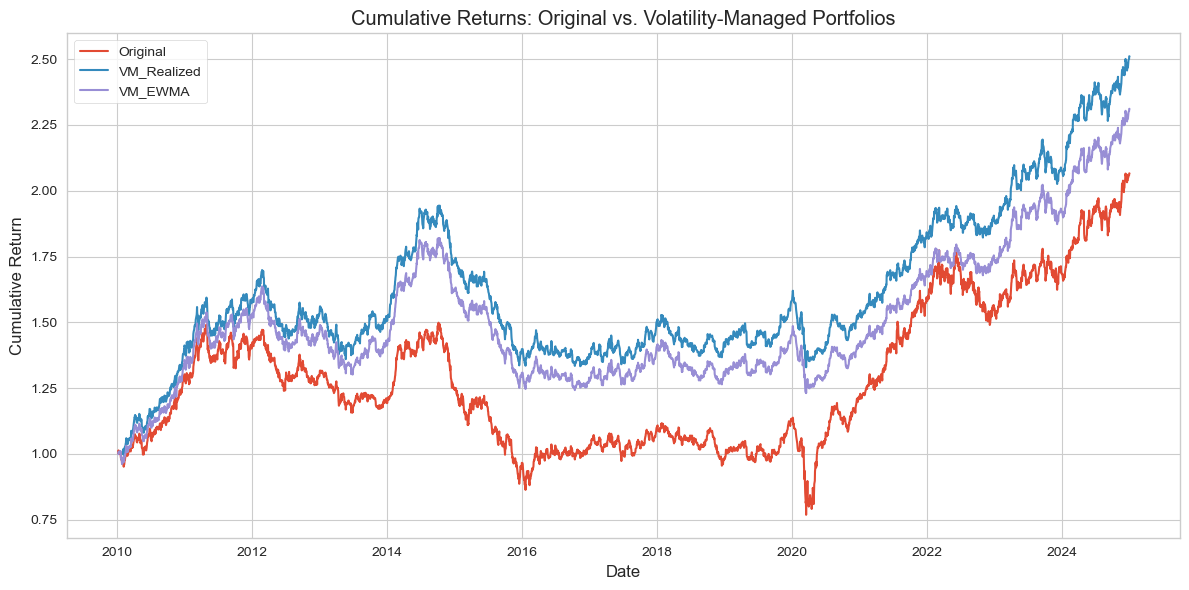

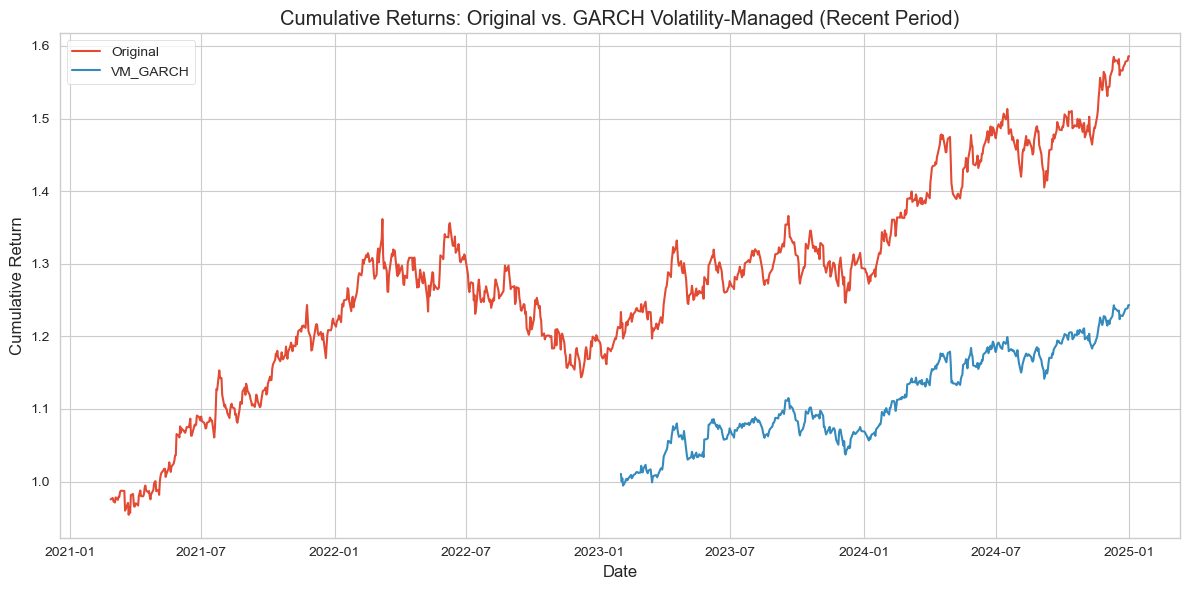

In [58]:
# Plot cumulative returns
plot_cumulative_returns(portfolios, 'Cumulative Returns: Original vs. Volatility-Managed Portfolios')
plot_cumulative_returns(recent_portfolios, 'Cumulative Returns: Original vs. GARCH Volatility-Managed (Recent Period)')

In [59]:
# Plot drawdowns
def plot_drawdowns(returns, title):
    """
    Plot drawdowns for multiple strategies
    """
    cum_returns = (1 + returns).cumprod()
    running_max = cum_returns.cummax()
    drawdowns = (cum_returns / running_max - 1) * 100
    
    plt.figure(figsize=(12, 6))
    for col in drawdowns.columns:
        plt.plot(drawdowns.index, drawdowns[col], label=col)
    
    plt.title(title)
    plt.xlabel('Date')
    plt.ylabel('Drawdown (%)')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

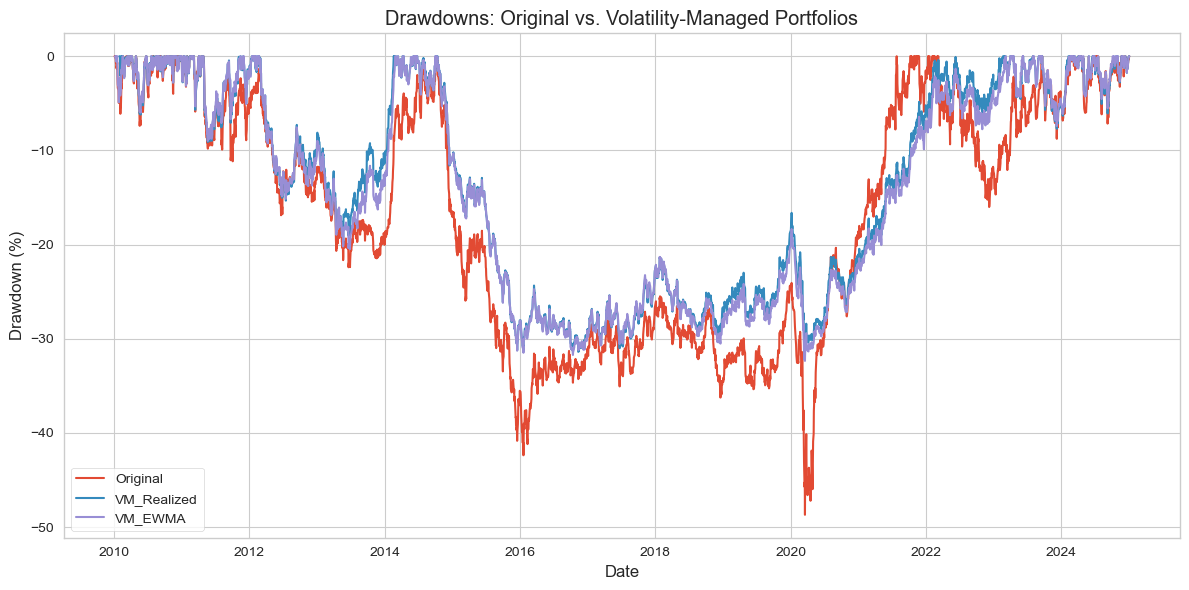

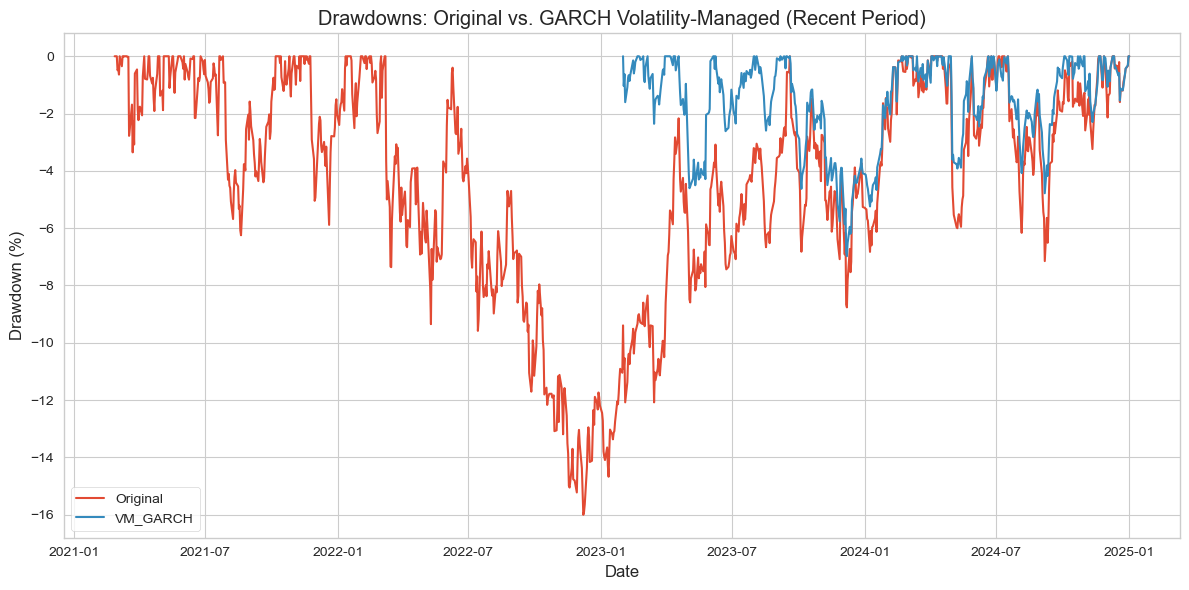

In [60]:
# Plot drawdowns
plot_drawdowns(portfolios, 'Drawdowns: Original vs. Volatility-Managed Portfolios')
plot_drawdowns(recent_portfolios, 'Drawdowns: Original vs. GARCH Volatility-Managed (Recent Period)')

## 6. Volatility Analysis

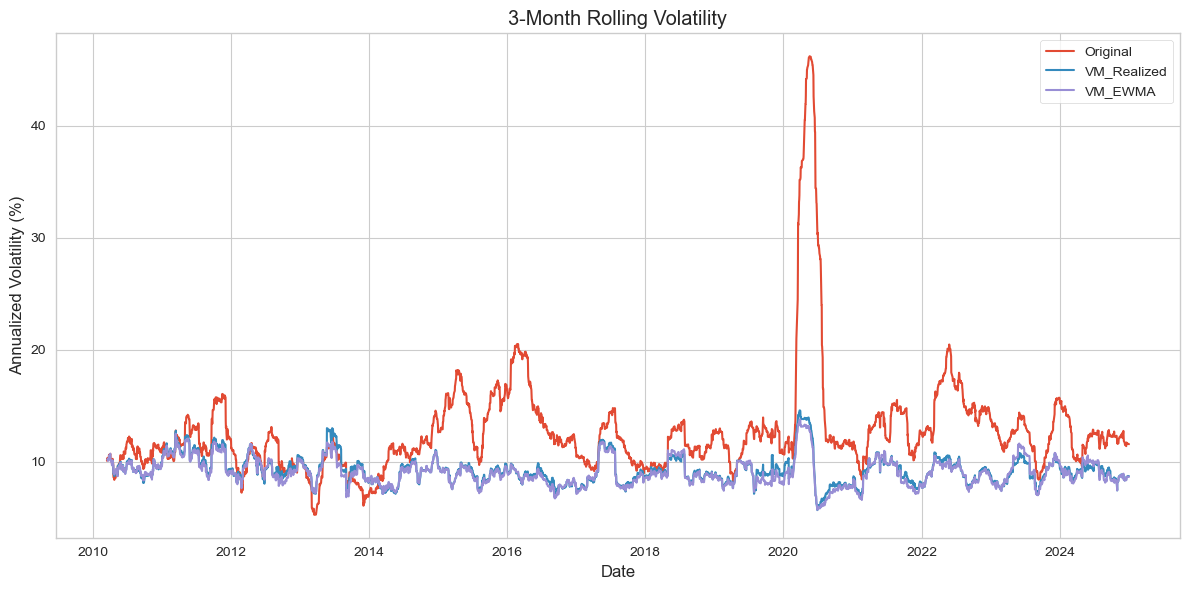

In [61]:
# Calculate rolling volatility of portfolios
rolling_vol = portfolios.rolling(window=63).std() * np.sqrt(252) * 100  # ~3 months, in percentage

plt.figure(figsize=(12, 6))
for col in rolling_vol.columns:
    plt.plot(rolling_vol.index, rolling_vol[col], label=col)

plt.title('3-Month Rolling Volatility')
plt.xlabel('Date')
plt.ylabel('Annualized Volatility (%)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

## 7. Return Distribution Analysis

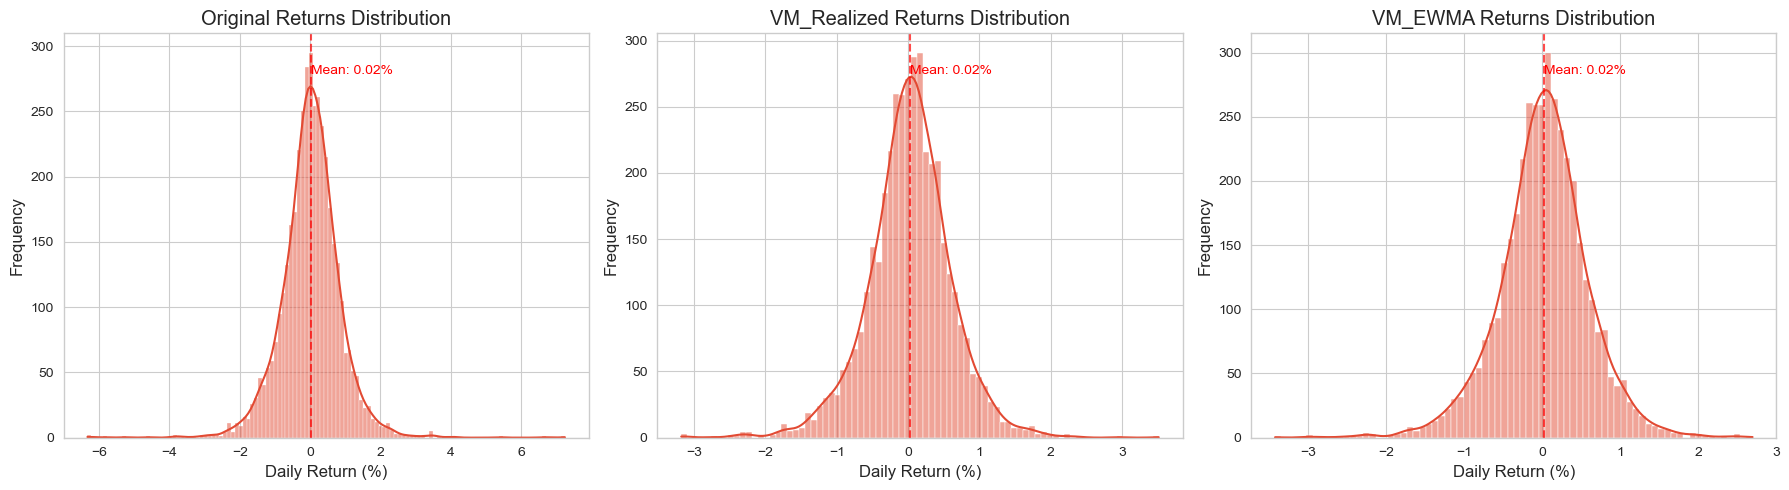

In [62]:
# Plot return distributions
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for i, col in enumerate(portfolios.columns):
    sns.histplot(portfolios[col] * 100, kde=True, ax=axes[i])  # Convert to percentage
    axes[i].set_title(f'{col} Returns Distribution')
    axes[i].set_xlabel('Daily Return (%)')
    axes[i].set_ylabel('Frequency')
    
    # Add vertical line at mean
    mean_return = portfolios[col].mean() * 100
    axes[i].axvline(mean_return, color='red', linestyle='--', alpha=0.7)
    axes[i].text(mean_return*1.1, axes[i].get_ylim()[1]*0.9, f'Mean: {mean_return:.2f}%', color='red')

plt.tight_layout()
plt.show()

## 8. Performance in Different Market Regimes

In [63]:
# Identify high/low volatility regimes
original_rolling_vol = realized_volatility(equal_weight_original, window=63).dropna()
vol_quantiles = original_rolling_vol.quantile([0.33, 0.66])

# Create regime classification
vol_regimes = pd.Series(index=original_rolling_vol.index)
vol_regimes[original_rolling_vol <= vol_quantiles.iloc[0]] = 'Low Vol'
vol_regimes[(original_rolling_vol > vol_quantiles.iloc[0]) & 
            (original_rolling_vol <= vol_quantiles.iloc[1])] = 'Medium Vol'
vol_regimes[original_rolling_vol > vol_quantiles.iloc[1]] = 'High Vol'

# Align with portfolio returns
aligned_portfolios = portfolios.loc[vol_regimes.index]

# Calculate performance by regime
regime_performance = {}
for regime in ['Low Vol', 'Medium Vol', 'High Vol']:
    regime_mask = vol_regimes == regime
    if regime_mask.sum() > 0:  # Ensure we have data for this regime
        regime_returns = aligned_portfolios.loc[regime_mask]
        regime_performance[regime] = calculate_performance_metrics(regime_returns)

# Display results
for regime, metrics in regime_performance.items():
    print(f"\nPerformance metrics for {regime} regime:")
    display(metrics)


Performance metrics for Low Vol regime:


,Original,VM_Realized,VM_EWMA
Ann_Return(%),7.799402,10.622357,10.524604
Ann_Vol(%),9.731903,9.032990,8.977067
Sharpe_Ratio,0.801426,1.175951,1.172388
Max_Drawdown(%),-26.152791,-22.613712,-22.942424
Sortino_Ratio,1.316231,1.963632,1.942501
Calmar_Ratio,0.298224,0.469731,0.458740



Performance metrics for Medium Vol regime:


,Original,VM_Realized,VM_EWMA
Ann_Return(%),2.393882,3.010042,2.085439
Ann_Vol(%),11.884357,9.451806,9.283071
Sharpe_Ratio,0.201431,0.318462,0.224650
Max_Drawdown(%),-35.359283,-29.262449,-30.235158
Sortino_Ratio,0.326087,0.514685,0.355417
Calmar_Ratio,0.067702,0.102864,0.068974



Performance metrics for High Vol regime:


,Original,VM_Realized,VM_EWMA
Ann_Return(%),5.709296,3.774692,3.704492
Ann_Vol(%),17.340483,9.525007,9.248496
Sharpe_Ratio,0.329247,0.396293,0.400551
Max_Drawdown(%),-34.948826,-24.710394,-24.248013
Sortino_Ratio,0.548891,0.652635,0.668088
Calmar_Ratio,0.163362,0.152757,0.152775


## 9. Conclusion and Insights

This analysis implemented the volatility-managed portfolio approach from Moreira & Muir (2017) on commodity data. Key findings include:

1. **Volatility forecasting methods**: We compared three methods (Realized, EWMA, GARCH) for volatility forecasting and their impact on portfolio performance.

2. **Performance enhancement**: The volatility-managed approaches generally aim to improve the risk-adjusted returns compared to the original equal-weighted portfolio.

3. **Drawdown reduction**: Volatility-managed portfolios typically exhibit reduced drawdowns during high volatility periods.

4. **Market regime performance**: The analysis showed how volatility-managed portfolios perform differently across low, medium, and high volatility regimes.

These results demonstrate the potential benefits of applying volatility targeting techniques to commodity investments, especially during turbulent market periods.